# Interactive Transects

This notebook illustrates how to make transects of tsunami depth over topography that can be interactively updated by selecting the transect.  

For this demo we use the same test data as used in Visualization Tutorial notebook `Crescent_City_Inundation.ipynb`, but it should work also with other combinations of topography and depth data.


### First set up some things needed in notebook....

In [10]:
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [11]:
from __future__ import print_function
import sys, os

In [12]:
# local module to read an ascii raster file:
import data_tools

import matplotlib.patches as patches
import matplotlib.path as path
import matplotlib.animation as animation
from IPython.display import HTML
from scipy.interpolate import RegularGridInterpolator

# # module for making animations:
# import JSAnimation
# import animation_tools

### Specify location of data files:

In [13]:
data_dir = '.'  # this location should work on Jupyterhub

# check that directory exists, raise an exception if not:
assert os.path.isdir(data_dir), '*** Data directory not found'

### Read in the topography data and define a function to make a contour plot:

In [14]:
topo_file = os.path.join(data_dir,'topo.asc')
topo_data_dict = data_tools.read_asc_file(topo_file, verbose=True)

topo = topo_data_dict['values']
X = topo_data_dict['X']
Y = topo_data_dict['Y']

ncols = 164
nrows = 146
xllcorner = -124.215
yllcorner = 41.7299
cellsize = 0.000277778
nodata_value = -9999


### Make `topo_func` function from raster data that can be evaluated anywhere

In [15]:
topo_func = RegularGridInterpolator((X[0,:], Y[:,0]), topo.T)

### Read in depth data

Define a function that reads in a single frame from the time-dependent solution.  Return the water depth and also `zeta`, which is defined to be the depth on-shore and the water surface elevation (depth + topography) offshore, since this is more interesting to view than the depth and should be continuous at the shoreline (where `topo == 0`).

In [16]:
def read_frame(frameno, verbose=False):
    time = 2*frameno  # minutes after earthquake
    fname = 'depth_%s.asc' % str(frameno).zfill(4)
    depth_file = os.path.join(data_dir, fname)
    if verbose:
        print("Reading %s at time %s minutes" % (depth_file, time))
        
    depth_data_dict = data_tools.read_asc_file(depth_file, verbose=False)

    depth = depth_data_dict['values']
    zeta = where(topo>0, depth, topo + depth)
    return depth, zeta, time

In [17]:
# Go through and do interpolations on all the frames once we've chosen a transect
def calc_transect(xprev,xnew,yprev,ynew):
    
    xi = linspace(xprev, xnew, 1000)
    yi = linspace(yprev, ynew, 1000)
    
    if (abs(xnew-xprev) > 0.5*abs(ynew-yprev)):
        ti = xi
        xtext = 'longitude'
    else:
        ti = yi
        xtext = 'latitude'
    
    # Interpolate the topo
    topo_func = RegularGridInterpolator((X[0,:], Y[:,0]), topo.T)
    Bi = topo_func(list(zip(xi,yi)))
    
    # In loop, interpolate the depths and calculate eta
    etas = np.empty((7, 1000))
    for frameno in range(7):
        depth, zeta, time = read_frame(frameno*10)
        depth_func = RegularGridInterpolator((X[0,:], Y[:,0]), depth.T)
        zi = depth_func(list(zip(xi,yi)))
        etas[frameno, :] = zi+Bi

    return Bi, etas, ti, xtext

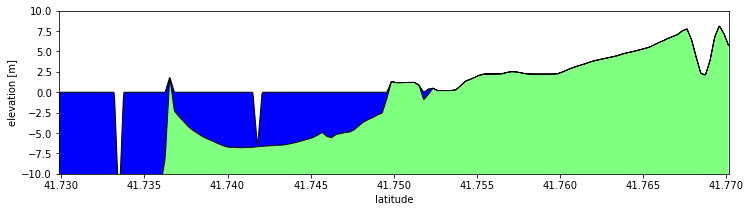

In [25]:
Bi, etas, ti, xtext = calc_transect(np.mean(X), np.mean(X), np.min(Y), np.max(Y))

def create_animation():
    fig = plt.figure(figsize=(12,3))
    ax = plt.subplot(111)

    # Draw patch for land
    codes_land = [path.Path.MOVETO] + [path.Path.LINETO]*1001 + [path.Path.CLOSEPOLY]
    vertices_land = [(ti[0], -1e6)] + list(zip(ti,Bi)) + [(ti[-1], -1e6), (0,0)]
    vertices_land = np.array(vertices_land, float)

    path_land = path.Path(vertices_land, codes_land)
    patch_land = patches.PathPatch(path_land, facecolor=[.5,1,.5], edgecolor='none')
    ax.add_patch(patch_land)

    # Draw patch for water between land and water surface
    codes_water = [path.Path.MOVETO] + [path.Path.LINETO]*1999 + [path.Path.CLOSEPOLY]
    vertices_water = list(zip(ti,etas[0,:])) + list(zip(ti,Bi))[::-1] + [(0,0)]
    vertices_water = np.array(vertices_water, float)

    path_water = path.Path(vertices_water, codes_water)
    patch_water = patches.PathPatch(path_water, facecolor='b', edgecolor='k')
    ax.add_patch(patch_water)


    # Set zoom limits (very important!)
    ax.set_xlim(ti[0], ti[-1])
    ax.set_ylim(-10, 10)

    # Labels
    ax.set_xlabel(xtext)
    ax.set_ylabel('elevation [m]')

    # Animation updates the vertices corresponding to the water's surface
    def animate(i):
        vertices_water[0:1000, 1] = etas[i,:]
        return [patch_water, ]

    ani = animation.FuncAnimation(fig, animate, 7, interval=500, blit=True)
    return ani

ani = create_animation()

In [26]:
# Display animation
HTML(ani.to_html5_video())